In [43]:
# Импорт нужных библиотек
import pyspark
import pandas as pd
from pygments.lexers import q
from pyspark.sql import SparkSession
import os

from pyspark.sql.functions import round, col, avg
from pyspark.sql import functions as F

import matplotlib.pyplot as plt

In [44]:
# Проверка переменной среды SPARK_HOME для Apache Spark (здесь будет путь до директории spark)
print(os.environ.get('SPARK_HOME'))

D:\Programs\spark


In [3]:
# Инициализация SparkSession
spark = SparkSession.builder.master("local").appName('Practise').getOrCreate()

In [4]:
# Чтение csv
df = spark.read.csv("creditcard_2023.csv", header=True, inferSchema=True)
df.limit(5).show()

+---+--------------------+--------------------+------------------+--------------------+-------------------+------------------+------------------+--------------------+-------------------+------------------+--------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------+-----+
| id|                  V1|                  V2|                V3|                  V4|                 V5|                V6|                V7|                  V8|                 V9|               V10|                 V11|               V12|                V13|                V14|                V15|                 V16|                V17|                V18|                V19|                V20|      

In [5]:
# Описательная статистика
df.describe().show()

+-------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+------------------+------------------+
|summary|               id|                  V1|                  V2|                  V3|                  V4|                  V5|                  V6|                  V7|                  V8|                  V9|                 V10|                 V11|                 V12|                 V13|                 V14|                 V15|     

In [6]:
# Округление каждого числа для лучшей читабельности
cols_to_round = [c for c in df.columns]

rounded_cols = [
    round(col(c), 3). alias(c) if c in cols_to_round
    else col(c) for c in cols_to_round
]

df_rounded = df.select(*rounded_cols)
df_rounded.show()

+---+------+------+-----+------+------+------+-----+------+------+-----+------+-----+------+-----+------+------+-----+------+------+------+------+------+------+------+------+------+------+------+--------+-----+
| id|    V1|    V2|   V3|    V4|    V5|    V6|   V7|    V8|    V9|  V10|   V11|  V12|   V13|  V14|   V15|   V16|  V17|   V18|   V19|   V20|   V21|   V22|   V23|   V24|   V25|   V26|   V27|   V28|  Amount|Class|
+---+------+------+-----+------+------+------+-----+------+------+-----+------+-----+------+-----+------+------+-----+------+------+------+------+------+------+------+------+------+------+------+--------+-----+
|  0|-0.261| -0.47|2.496|-0.084|  0.13| 0.733|0.519| -0.13| 0.727|0.638|-0.987|0.293|-0.941|0.549| 1.805| 0.216|0.512| 0.334| 0.124| 0.091|-0.111| 0.218|-0.135| 0.166| 0.126|-0.435|-0.081|-0.151| 17982.1|    0|
|  1| 0.985|-0.356|0.558| -0.43| 0.277| 0.429|0.406|-0.133| 0.347| 0.53|  0.14|1.564| 0.574|0.628| 0.706| 0.789|0.404| 0.202|-0.341|-0.234|-0.195|-0.606| 0.

In [7]:
# Проверяем счет строк по группам (Class) - факт (1) или отсутствие (0) фрода.
grouped_class_df = df.groupBy("Class").agg(F.count("Class").alias("countClass"))
grouped_class_df.show()

+-----+----------+
|Class|countClass|
+-----+----------+
|    1|    284315|
|    0|    284315|
+-----+----------+



In [8]:
# Переименуем каждую строку в тип "avg_{строка}", так как агрегируем по среднему
avg_expressions = [avg(col_name).alias(f"avg_{col_name}") for col_name in df.columns]
df_avg = df.agg(*avg_expressions)

In [9]:
# Транспонируем для лучшей читабельности
df_avg.transpose().show(n= df_avg.transpose().count(), truncate=False)

+----------+-----------------------+
|key       |284314.5               |
+----------+-----------------------+
|avg_V1    |4.580822021134422E-15  |
|avg_V2    |-2.76384792336602E-15  |
|avg_V3    |4.2737278074270865E-15 |
|avg_V4    |1.5610622530122892E-15 |
|avg_V5    |3.3396495740672744E-15 |
|avg_V6    |-5.758016507012542E-16 |
|avg_V7    |-7.805311265061446E-16 |
|avg_V8    |2.367184563994045E-15  |
|avg_V9    |-6.090701905195489E-15 |
|avg_V10   |-7.165531653171163E-15 |
|avg_V11   |-1.261645394647637E-14 |
|avg_V12   |-2.8918038457440768E-15|
|avg_V13   |-1.1835922819970224E-15|
|avg_V14   |-1.6122446219635118E-15|
|avg_V15   |-1.001255092608292E-15 |
|avg_V16   |-7.165531653171163E-15 |
|avg_V17   |7.152736060933358E-15  |
|avg_V18   |1.164398893640314E-15  |
|avg_V19   |-2.2328308454970856E-15|
|avg_V20   |2.8918038457440768E-15 |
|avg_V21   |8.637024760518813E-16  |
|avg_V22   |6.429785099497338E-16  |
|avg_V23   |2.3152024705279595E-16 |
|avg_V24   |-7.613377381494361E-16 |
|

In [10]:
# Отфильтруем датафрейм - только строки, где столбец "Class" = 1
df_avg_class_1 = (df.filter(col("Class") == 1)).agg(*avg_expressions)

# Переименуем столбец из числового названия в название "value"
df_avg_class_1_transposed = df_avg_class_1.transpose().withColumnRenamed("426186.01228566904", "value")
df_avg_class_1_transposed.show(n= df_avg_class_1_transposed.count(), truncate=False)

+----------+---------------------+
|key       |value                |
+----------+---------------------+
|avg_V1    |-0.5057610150941905  |
|avg_V2    |0.49187802825781674  |
|avg_V3    |-0.6820954647464685  |
|avg_V4    |0.7359808565710118   |
|avg_V5    |-0.3386389623313892  |
|avg_V6    |-0.43508823958896137 |
|avg_V7    |-0.49123416156803    |
|avg_V8    |0.14429382694638357  |
|avg_V9    |-0.5855216713180041  |
|avg_V10   |-0.6736650416630406  |
|avg_V11   |0.7242781571397987   |
|avg_V12   |-0.7685793328121407  |
|avg_V13   |-0.07110514335464271 |
|avg_V14   |-0.8056692033482068  |
|avg_V15   |-0.037948155104995544|
|avg_V16   |-0.5735112908795688  |
|avg_V17   |-0.47637650032081696 |
|avg_V18   |-0.4100909344080944  |
|avg_V19   |0.2440814579040609   |
|avg_V20   |0.17985104660648987  |
|avg_V21   |0.10964021915688202  |
|avg_V22   |0.014097879209650294 |
|avg_V23   |0.010254587927718014 |
|avg_V24   |-0.13010656532794485 |
|avg_V25   |0.061846957937431196 |
|avg_V26   |0.071051

In [11]:
# Создадим вычисляемое поле с округлением по "value"
df_avg_class_1_transposed_round = df_avg_class_1_transposed.withColumn('avg_value_class_1', round(col("value"), 2))
df_avg_class_1_transposed_round.show(n= df_avg_class_1_transposed_round.count(), truncate=False)

+----------+---------------------+-----------------+
|key       |value                |avg_value_class_1|
+----------+---------------------+-----------------+
|avg_V1    |-0.5057610150941905  |-0.51            |
|avg_V2    |0.49187802825781674  |0.49             |
|avg_V3    |-0.6820954647464685  |-0.68            |
|avg_V4    |0.7359808565710118   |0.74             |
|avg_V5    |-0.3386389623313892  |-0.34            |
|avg_V6    |-0.43508823958896137 |-0.44            |
|avg_V7    |-0.49123416156803    |-0.49            |
|avg_V8    |0.14429382694638357  |0.14             |
|avg_V9    |-0.5855216713180041  |-0.59            |
|avg_V10   |-0.6736650416630406  |-0.67            |
|avg_V11   |0.7242781571397987   |0.72             |
|avg_V12   |-0.7685793328121407  |-0.77            |
|avg_V13   |-0.07110514335464271 |-0.07            |
|avg_V14   |-0.8056692033482068  |-0.81            |
|avg_V15   |-0.037948155104995544|-0.04            |
|avg_V16   |-0.5735112908795688  |-0.57       

In [12]:
# Отфильтруем датафрейм - только строки, где столбец "Class" = 0

df_avg_class_0 = (df.filter(col("Class") == 0)).agg(*avg_expressions)

# Переименуем столбец из числового названия в название "value"
df_avg_class_0_transposed = df_avg_class_0.transpose().withColumnRenamed("142442.98771433093", "value")
df_avg_class_0_transposed.show(n= df_avg_class_0_transposed.count(), truncate=False)

+----------+---------------------+
|key       |value                |
+----------+---------------------+
|avg_V1    |0.5057610150941826   |
|avg_V2    |-0.4918780282578416  |
|avg_V3    |0.6820954647464795   |
|avg_V4    |-0.7359808565709955  |
|avg_V5    |0.33863896233138396  |
|avg_V6    |0.43508823958894677  |
|avg_V7    |0.4912341615680376   |
|avg_V8    |-0.14429382694637294 |
|avg_V9    |0.5855216713180007   |
|avg_V10   |0.6736650416630231   |
|avg_V11   |-0.7242781571398229  |
|avg_V12   |0.7685793328121439   |
|avg_V13   |0.07110514335464047  |
|avg_V14   |0.8056692033482044   |
|avg_V15   |0.03794815510499446  |
|avg_V16   |0.5735112908795534   |
|avg_V17   |0.4763765003208232   |
|avg_V18   |0.41009093440810074  |
|avg_V19   |-0.24408145790405805 |
|avg_V20   |-0.17985104660648488 |
|avg_V21   |-0.1096402191568785  |
|avg_V22   |-0.014097879209650842|
|avg_V23   |-0.010254587927718002|
|avg_V24   |0.1301065653279484   |
|avg_V25   |-0.0618469579374302  |
|avg_V26   |-0.07105

In [13]:
# Создадим вычисляемое поле с округлением по "value"
df_avg_class_0_transposed_round = df_avg_class_0_transposed.withColumn('avg_value_class_0', round(col("value"), 2))
df_avg_class_0_transposed_round.show(n= df_avg_class_0_transposed_round.count(), truncate=False)

+----------+---------------------+-----------------+
|key       |value                |avg_value_class_0|
+----------+---------------------+-----------------+
|avg_V1    |0.5057610150941826   |0.51             |
|avg_V2    |-0.4918780282578416  |-0.49            |
|avg_V3    |0.6820954647464795   |0.68             |
|avg_V4    |-0.7359808565709955  |-0.74            |
|avg_V5    |0.33863896233138396  |0.34             |
|avg_V6    |0.43508823958894677  |0.44             |
|avg_V7    |0.4912341615680376   |0.49             |
|avg_V8    |-0.14429382694637294 |-0.14            |
|avg_V9    |0.5855216713180007   |0.59             |
|avg_V10   |0.6736650416630231   |0.67             |
|avg_V11   |-0.7242781571398229  |-0.72            |
|avg_V12   |0.7685793328121439   |0.77             |
|avg_V13   |0.07110514335464047  |0.07             |
|avg_V14   |0.8056692033482044   |0.81             |
|avg_V15   |0.03794815510499446  |0.04             |
|avg_V16   |0.5735112908795534   |0.57        

In [14]:
# соединяем эти 2 датафрейма по ключу key
df_classes_joined = df_avg_class_0_transposed_round.join(
    df_avg_class_1_transposed_round,
    on = 'key',
    how = 'inner'
)

df_classes_joined.show(n= df_classes_joined.count(), truncate=False)

+----------+---------------------+-----------------+---------------------+-----------------+
|key       |value                |avg_value_class_0|value                |avg_value_class_1|
+----------+---------------------+-----------------+---------------------+-----------------+
|avg_V1    |0.5057610150941826   |0.51             |-0.5057610150941905  |-0.51            |
|avg_V2    |-0.4918780282578416  |-0.49            |0.49187802825781674  |0.49             |
|avg_V3    |0.6820954647464795   |0.68             |-0.6820954647464685  |-0.68            |
|avg_V4    |-0.7359808565709955  |-0.74            |0.7359808565710118   |0.74             |
|avg_V5    |0.33863896233138396  |0.34             |-0.3386389623313892  |-0.34            |
|avg_V6    |0.43508823958894677  |0.44             |-0.43508823958896137 |-0.44            |
|avg_V7    |0.4912341615680376   |0.49             |-0.49123416156803    |-0.49            |
|avg_V8    |-0.14429382694637294 |-0.14            |0.1442938269463835

In [15]:
# Сортируем по avg_value_class_1 по убывающей, удаляем строки key: "avg_Amount", "avg_Class"
df_classes_joined_sorted = df_classes_joined.sort("avg_value_class_1", ascending = True)
df_classes_joined_sorted = df_classes_joined_sorted.filter(~col("key").isin(["avg_Amount", "avg_Class"]))
df_classes_joined_sorted.show(n= df_classes_joined_sorted.count(), truncate=False)

+-------+---------------------+-----------------+---------------------+-----------------+
|key    |value                |avg_value_class_0|value                |avg_value_class_1|
+-------+---------------------+-----------------+---------------------+-----------------+
|avg_V14|0.8056692033482044   |0.81             |-0.8056692033482068  |-0.81            |
|avg_V12|0.7685793328121439   |0.77             |-0.7685793328121407  |-0.77            |
|avg_V3 |0.6820954647464795   |0.68             |-0.6820954647464685  |-0.68            |
|avg_V10|0.6736650416630231   |0.67             |-0.6736650416630406  |-0.67            |
|avg_V9 |0.5855216713180007   |0.59             |-0.5855216713180041  |-0.59            |
|avg_V16|0.5735112908795534   |0.57             |-0.5735112908795688  |-0.57            |
|avg_V1 |0.5057610150941826   |0.51             |-0.5057610150941905  |-0.51            |
|avg_V7 |0.4912341615680376   |0.49             |-0.49123416156803    |-0.49            |
|avg_V17|0

In [16]:
# переводим в dataframe из spark в pandas для визуализации
pandas_df = df_classes_joined_sorted.toPandas()
pandas_df = pandas_df.drop(columns=[pandas_df.columns[1], pandas_df.columns[3]], axis = 1)
print(pandas_df)

        key  avg_value_class_0  avg_value_class_1
0   avg_V14               0.81              -0.81
1   avg_V12               0.77              -0.77
2    avg_V3               0.68              -0.68
3   avg_V10               0.67              -0.67
4    avg_V9               0.59              -0.59
5   avg_V16               0.57              -0.57
6    avg_V1               0.51              -0.51
7    avg_V7               0.49              -0.49
8   avg_V17               0.48              -0.48
9    avg_V6               0.44              -0.44
10  avg_V18               0.41              -0.41
11   avg_V5               0.34              -0.34
12  avg_V24               0.13              -0.13
13  avg_V13               0.07              -0.07
14  avg_V15               0.04              -0.04
15  avg_V22              -0.01               0.01
16  avg_V23              -0.01               0.01
17  avg_V25              -0.06               0.06
18  avg_V26              -0.07               0.07


In [17]:
# Выводим названия столбцов
print(pandas_df.columns)

Index(['key', 'avg_value_class_0', 'avg_value_class_1'], dtype='object')


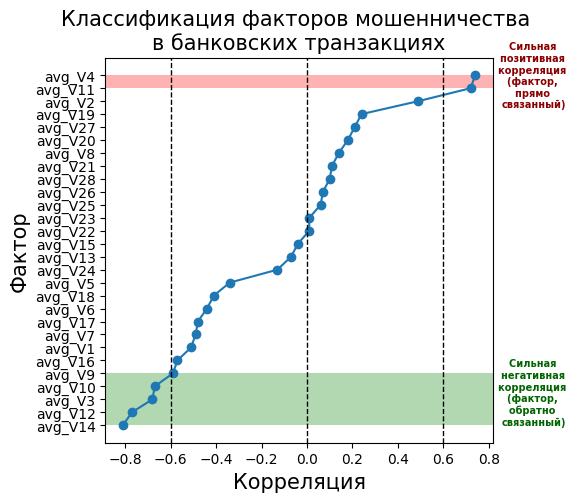

In [45]:
# Выводим визуализацию
# Линейный график 500х500 пикселей
fig, ax = plt.subplots(figsize = (5, 5))

# Добавим точки на значения графика
ax.plot(pandas_df['avg_value_class_1'], pandas_df['key'], marker = "o")

# 3 горизонтальные линии: x = -0.6, 0, 0.6, обозначают порог сильной корреляции
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.axvline(x=-0.6, color='black', linestyle='--', linewidth=1)
plt.axvline(x=0.6, color='black', linestyle='--', linewidth=1)

# Порог покраски зеленой области (негативная корреляция)
y_start_1 = 0
y_end_1 = 4

y_text_1 = ((y_start_1 + y_end_1) / 2) -2 # Центральная позиция текста по y
x_text_1 = 1 # Центральная позиция текста по x

# Зеленая область с ранее определенными переменными, зеленым цветом и прозрачностью 30%
ax.axhspan(ymin=y_start_1,
           ymax=y_end_1,
           facecolor='Green',
           alpha=0.3,
           label='Green Zone')

# Текст с ранее определенными переменными, размером шрифта 7, типом - жирный, цветом - "темно-зеленый"
ax.text(x=x_text_1,
        y=y_text_1,
        s='Сильная \nнегативная \nкорреляция \n(фактор, \nобратно \nсвязанный)', # The text content
        horizontalalignment='center', # Center the text on the x_text position
        fontsize=7,
        color='darkgreen',
        weight='bold')

# Порог покраски красной области (позитивная корреляция)
y_start_2 = 26
y_end_2 = 27

y_text_2 = ((y_start_2 + y_end_2) / 2) -2 # Центральная позиция текста по y
x_text_2 = 1 # Центральная позиция текста по x

# Красная область с ранее определенными переменными, зеленым цветом и прозрачностью 30%
ax.axhspan(ymin=y_start_2,
           ymax=y_end_2,
           facecolor='red',
           alpha=0.3,
           label='Red Zone')

# Текст с ранее определенными переменными, размером шрифта 7, типом - жирный, цветом - "темно-красный"
ax.text(x=x_text_2,
        y=y_text_2,
        s='Сильная \nпозитивная \nкорреляция \n(фактор, \nпрямо \nсвязанный)', # The text content
        horizontalalignment='center',
        fontsize=7,
        color='darkred',
        weight='bold')


plt.xticks(fontsize=10) # размер шрифта значений по x - 10
plt.title('Классификация факторов мошенничества \nв банковских транзакциях', fontsize = 15) # название графика
plt.ylabel('Фактор', fontsize=15) # Название оси y
plt.xlabel('Корреляция', fontsize=15) # Название оси x

plt.show() # показать график